<a href="https://colab.research.google.com/github/hygjob/pytorch-playground/blob/master/char_rnn_classification_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline


문자 단위 RNN으로 이름 분류하기  
*********************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_
  **번역**: `황성수 <https://github.com/adonisues>`_


단어를 분류하기 위해 기본적인 문자 단위 RNN을 만들고 훈련 할 것입니다. 문자 단위 RNN은 문자의 연속을 읽어 들여서 각 단계의 예측과 "hidden state" 출력하고 다음 단계에 이전 hidden state를 전달합니다. 즉 단어가 속한 클래스 같은 출력을 최종 예측으로 선택합니다.

특히, 18개 언어로 된 수천 개의 성(姓)을 훈련시키고, 철자에 따라 이름이 어떤 언어인지 예측합니다:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**추천 자료:**

최소한 Pytorch를 설치했고, Python을 알고, Tensor를 이해한다고 가정합니다.:

-  http://pytorch.org/ 설치 안내를 위한 자료 
-  :doc:`/beginner/deep_learning_60min_blitz` 일반적인 PyTorch 시작을 위한 자료
-  :doc:`/beginner/pytorch_with_examples` 넓고 깊은 통찰을 위한 자료
-  :doc:`/beginner/former_torchies_tutorial` 이전 Lua Torch 사용자를 위한 자료

RNN과 그 작동 방식을 아는 것 또한 유용합니다.:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <http://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   실생활 예들을 보여 줍니다 
-  `Understanding LSTM
   Networks <http://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   특히 LSTM에 관한 것이지만 일반적인 RNN에 대한 정보입니다. 


데이터 준비하기
==================

.. NOTE::
   `여기 <https://download.pytorch.org/tutorial/data.zip>`__ 에서 데이터를 다운 받고,
   현재 디렉토리에 압축을 푸십시오.



``data/names`` 디렉토리에는 "[Language].txt" 라는 18 개의 텍스트 파일이 포함되어 있습니다. 각 파일에는 한 줄에 하나의 이름이 포함되어 있으며 대부분 로마자로 표시되어 있습니다 (그러나, 유니 코드에서 ASCII로 변환해야 함).

언어 별 이름 목록 사전이 ``{language : [names ...]}`` 로 끝날 것입니다. 일반 변수 "category" 와 "line" (이 경우 언어와 이름 용)은 이후의 확장성을 위해 사용됩니다.



In [2]:
!wget https://download.pytorch.org/tutorial/data.zip

--2019-09-18 04:57:17--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.241.56, 13.224.241.66, 13.224.241.122, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.241.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  4.81MB/s    in 0.6s    

2019-09-18 04:57:18 (4.81 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [3]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니 코드 문자열을 일반 ASCII로 변환하십시오. http://stackoverflow.com/a/518232/2809427 에 감사드립니다.
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# 언어별 이름 목록인 category_lines 사전을 만드십시오.
category_lines = {}
all_categories = []

# 파일을 읽고 라인으로 분리하십시오
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Greek.txt', 'data/names/Korean.txt', 'data/names/Spanish.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Irish.txt', 'data/names/French.txt', 'data/names/Japanese.txt', 'data/names/Dutch.txt', 'data/names/Polish.txt', 'data/names/Czech.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Vietnamese.txt', 'data/names/Chinese.txt', 'data/names/Italian.txt', 'data/names/English.txt', 'data/names/Arabic.txt']
Slusarski


이제 각 카테고리(언어)를 줄(이름) 목록에 매핑하는 사전인 
``category_lines`` 가 있습니다. 또한 나중에 참조 할 수 있도록 
``all_categories`` (언어 목록)와 ``n_categories`` 를 추적했습니다.




In [5]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


이름을 Tensor 로 변경
--------------------------

이제는 모든 이름을 체계화 했으므로 이를 활용하기 위해 Tensor로 
전환해야 합니다.

하나의 문자를 표현하기 위해, 크기가 ``<1 x n_letters>`` 인 
"one-hot vector" 를 사용합니다. one-hot 벡터는 현재 문자의 
주소에만 1을 값을 가지고 그외에 나머지는 0으로 채워진다. 
예시 `` "b"= <0 1 0 0 0 ...> `` .

단어를 만들기 위해 그 묶음을 2 차원 행렬 
``<line_length x 1 x n_letters>`` 에 결합시킵니다.

이 추가 1 차원은 PyTorch가 모든 것이 뱃치(batch)에 있다고 가정하기 
때문에 발생합니다. 여기서는 뱃치 크기 1을 사용하고 있습니다.




In [6]:
import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한 문자를 <1 x n_letters> Tensor로 변환하기
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 문자 벡터의 어레이로 변경하기
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


네트워크 생성
====================

Autograd 전에, Torch에서 RNN(recurrent neural network) 생성에는 
여러 타임 스텝에서 Layer의 파라미터를 복제하는 작업을 포함합니다.
이제 Layer는 그래프 자체에서 완전히 처리되는 Hidden State와 
Gradient를 가지게 됩니다. 즉, feed-forward layer 같은 매우 "순수한" 
방법으로 RNN을 구현할 수 있습니다.

이 RNN 모듈 (대부분 `Torch 사용자를 위한 PyTorch 튜토리얼
<http://pytorch.org/tutorials/beginner/former_torchies/
nn_tutorial.html#example-2-recurrent-net>`__ 에서 복사). 
은 input 및 hidden state에서 작동하는 2개의 선형 레이어이며, 
출력 후에 LogSoftmax 레이어가 있습니다.

.. figure:: https://i.imgur.com/Z2xbySO.png
   :alt:





In [0]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

이 네트워크의 한 단계를 실행하려면 입력(현재 문자의 Tensor)과 
이전의 hidden state (처음에는 0으로 초기화)를 전달해야 합니다.
출력(각 언어의 확률)과 다음 hidden state (다음 단계를 위해 유지)를 
돌려 받습니다.

PyTorch 모듈은 Tensors에서 바로 작동하는 대신에 Variables에서 
작동한다는 것을 기억하십시오.




In [0]:
input = Variable(letterToTensor('A'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input, hidden)

효율성을 위해서 매 단계마다 새로운 Tensor를 만들고 싶지 않기 때문에
``letterToTensor`` 대신 ``lineToTensor`` 를 잘라서 사용할 
것입니다. 이것은 Tensor의 사전 연산(pre-computing) 뱃치에 의해 
더욱 최적화 될 수 있습니다.




In [9]:
input = Variable(lineToTensor('Albert'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8551, -3.0100, -2.8571, -2.9539, -2.9720, -2.8926, -2.9063, -2.8324,
         -2.9413, -2.8309, -2.7972, -2.9239, -2.8702, -2.9245, -2.8642, -2.9129,
         -2.8640, -2.8443]], grad_fn=<LogSoftmaxBackward>)


보시다시피 출력은 ``<1 x n_categories>`` Tensor이고, 모든 항목은 
해당 카테고리의 우도(likelihood) 입니다 (더 높은 것이 더 가능성 높음).




학습
========
학습 준비
----------------------

학습으로 들어가기 전에 몇몇 도움되는 함수를 만들어야합니다. 첫째는
네트워크의 알고 있는 각 카테고리의 우도로 출력을 해석하기 입니다.
가장 큰 값의 주소를 알기 위해서 ``Tensor.topk`` 를 쓸 수 있습니다.




In [10]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # Tensor out of Variable with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Czech', tensor(10))


또한 학습 예시(이름과 언어)를 얻는 빠른 방법을 원할 것입니다.




In [11]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Chinese / line = Yun
category = Greek / line = Vassilopulos
category = Japanese / line = Choshi
category = Vietnamese / line = Thao
category = Chinese / line = Chieu
category = Polish / line = Wojewodzki
category = Czech / line = Kudrna
category = Greek / line = Rorris
category = Portuguese / line = Santana
category = Arabic / line = Tuma


네트워크 학습
--------------------

이제 이 네트워크를 훈련하는 데 필요한 모든 예시를 보여주고 추측을 
하고, 만일 잘못되었다면 말해줍니다.

RNN의 마지막 레이어가 ``nn.LogSoftmax`` 이므로 손실 함수로 
``nn.NLLLoss`` 가 적합합니다.




In [0]:
criterion = nn.NLLLoss()

학습의 각 루프는 다음을 실행 합니다.:

-  입력과 목표 tensor 생성
-  0 로 초기화된 hidden state 생성 
-  각 문자를 읽기 

   -  다음 문자를 위한 hidden state 유지

-  목표와 출력 비교
-  역전파
-  출려과 손실 리턴




In [0]:
learning_rate = 0.005 # 이것을 너무 높게 설정하면 폭발할 수 있고 너무 낮으면 학습이 되지 않을 수 있습니다.

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # learning rate를 곱한 파리미터의 경사도를 파리미터 값에 더합니다.
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    #return output, loss.data[0]
    return output, loss.data.item()

이제 예제를 사용하여 실행해야합니다. ``train`` 함수가 출력과 손실을 
반환하기 때문에 추측을 출력하고 도식화를 위한 손실을 추적 할 수 
있습니다. 1000개의 예제가 있기 때문에 모든 ``print_every`` 예제만 
출력하고 손실의 평균을 얻습니다.




In [16]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 소실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 2.2175 Sha / Korean ✗ (Chinese)
10000 10% (0m 16s) 1.2014 Czajkowski / Polish ✓
15000 15% (0m 25s) 1.0346 Yeon / Korean ✓
20000 20% (0m 33s) 2.3388 Winograd / Scottish ✗ (Polish)
25000 25% (0m 41s) 0.3980 Henderson / Scottish ✓
30000 30% (0m 50s) 1.7146 Santos / Greek ✗ (Portuguese)
35000 35% (0m 58s) 1.6522 Golofaev / Russian ✓
40000 40% (1m 6s) 1.7847 Han / Chinese ✗ (Vietnamese)
45000 45% (1m 15s) 1.0309 Raghailligh / Irish ✓
50000 50% (1m 23s) 0.8069 Sauvageau / French ✓
55000 55% (1m 31s) 1.7890 Pinheiro / Japanese ✗ (Portuguese)
60000 60% (1m 39s) 0.0862 Vyrubov / Russian ✓
65000 65% (1m 48s) 0.8963 Fei / Chinese ✓
70000 70% (1m 56s) 1.4396 Hendry / Scottish ✗ (English)
75000 75% (2m 4s) 1.4423 Zapatero / Spanish ✓
80000 80% (2m 12s) 2.8284 Jasso / Arabic ✗ (Spanish)
85000 85% (2m 21s) 2.5514 Bonner / German ✗ (French)
90000 90% (2m 29s) 3.9632 Niftrik / Czech ✗ (Dutch)
95000 95% (2m 37s) 1.6078 Abascal / Czech ✗ (Spanish)
100000 100% (2m 45s) 1.0890 Kuang / Chine

결과 도식화
--------------------

``all_losses`` 를 이용한 역사적인 손실 도식화는 
네트워크의 학습을 보여준다




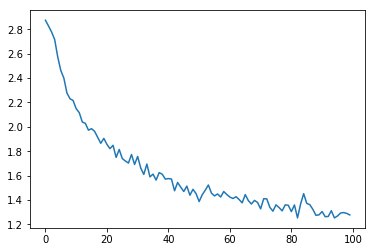

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

결과 평가
======================

네트워크가 다른 카테고리에서 얼마나 잘 작동하는지 보려면 
네트워크에서 추측한 언어(행)와 실제 언어(행)를 나타내는 
혼란 행열(confusion matrix)을 만듭니다. 혼란 행렬을 계산하기 위해 
``evaluate()`` 로 많은 수의 샘플을 네트워크에 실행합니다. 
``evaluate()`` 은 ``train ()`` 과 역전파를 빼면 동일합니다.




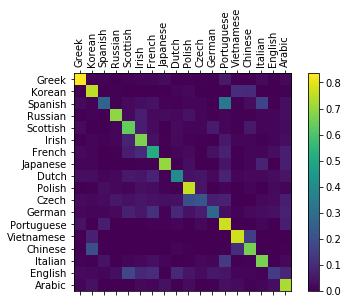

In [18]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# 올바르게 추측 된 예시와 기록을 살펴보십시오.  
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나눔으로써 정규화하십시오.
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 강제로 레이블 지정 
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

주축에서 벗어난 밝은 점을 선택하여 잘못 추측한 언어를 표시 
할 수 있습니다. 예를 들어 한국어는 중국어로 이탈리아어로 스페인어로.
그리스어는 매우 잘되는 것으로 영어는 매우 나쁜것으로 보입니다.
(아마도 다른 언어들과 중첩되기 때문에)




사용자 입력으로 실행
---------------------




In [19]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # 최고 N 카테고리 얻기
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.45) Russian
(-1.67) Czech
(-2.62) English

> Jackson
(-0.23) Scottish
(-2.15) English
(-3.55) Russian

> Satoshi
(-1.26) Portuguese
(-1.38) Japanese
(-1.63) Arabic


In [24]:
predict('Chulsu')


> Chulsu
(-1.65) German
(-1.91) English
(-2.02) Japanese


`실용 PyTorch 저장소
<https://github.com/spro/practical-pytorch/tree/master/char-rnn-classification>`__
의 최종 버전 스크립트는 위 코드를 몇개의 파일로 분할했습니다.:

-  ``data.py`` (파일 읽기)
-  ``model.py`` (RNN 정의)
-  ``train.py`` (학습 실행)
-  ``predict.py`` (커멘드 라인 인자로 ``predict()`` 실행)
-  ``server.py`` (bottle.py를 사용하여 JSON API로 예측 제공)

학습과 네트워크 저장을 위해 ``train.py`` 실행.

이름으로 예측을 보기 위해 ``predict.py`` 실행:

::

    $ python predict.py Hazaki
    (-0.42) Japanese
    (-1.39) Polish
    (-3.51) Czech

``server.py`` 를 실행하고 예측의 JSON 출력을 얻기 위해 
http://localhost:5533/Yourname 방문.




연습
=========

-  "line -> category" 의 다른 데이터 집합으로 시도해보십시오, 예를 들어:

   -  단어 -> 언어
   -  이름 -> 성별
   -  캐릭터 이름 -> 작가
   -  페이지 제목 -> 블로그 또는 서브레딧

-  더 크고 더 나은 모양의 네트워크로 더 나은 결과를 얻으십시오.

   -  더많은 선형 layer 추가해 보십시오
   -  ``nn.LSTM`` 과 ``nn.GRU`` layer 추가해 보십시오
   -  여러 개의 이런 RNN을 상위 수준 네트워크로 결합해 보십시오


